# MLP
Convert CNN_264 to an MLP.

More neurons.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-27 15:05:04.406781


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

2023-03-27 15:05:04.450991: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU device not found
/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/


2023-03-27 15:05:14.719928: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=50 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.10.0
sklearn 1.1.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 15:05:17.670832
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16512     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,897
Trainable params: 24,897
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 15:05:18.040340
Load RCI from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 15:05:34.086767

Training # 1 1
2023-03-27 15:05:34.086814
2023-03-27 15:05:34.086838
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 15:05:34.156772


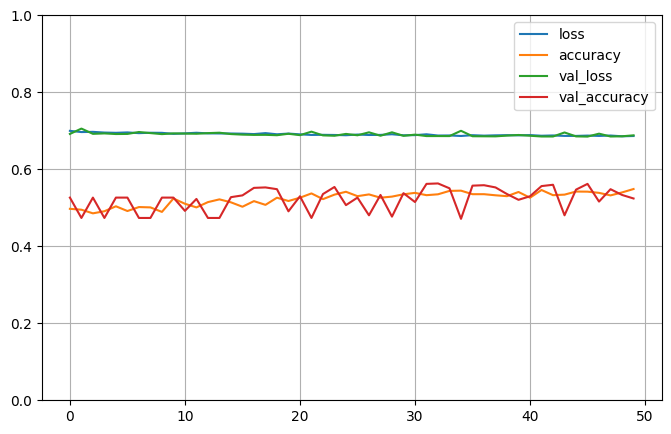


2023-03-27 15:05:56.248392

Testing # 1 1
2023-03-27 15:05:56.248435
2023-03-27 15:05:56.248453
PREDICT
2023-03-27 15:05:56.261760
Test 1:0 458:412 52.64%
Predict 1:0 446:424 51.26%
Test sizes (870, 257) (870,)
Range of scores: 0.2541164 to 0.5414064
Score threshold 0.5
Confusion matrix
 [[211 201]
 [213 245]]
Normalized matrix
 [[0.24252874 0.23103448]
 [0.24482759 0.2816092 ]]


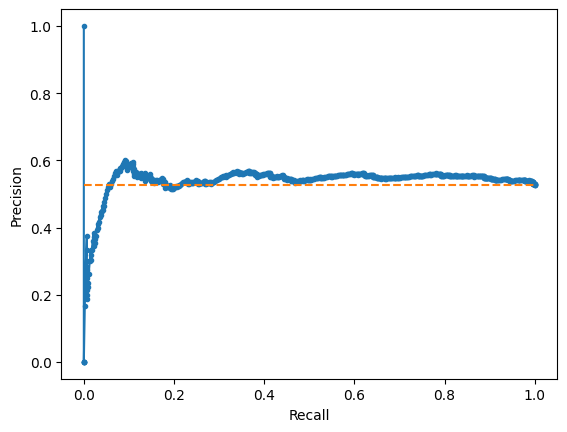

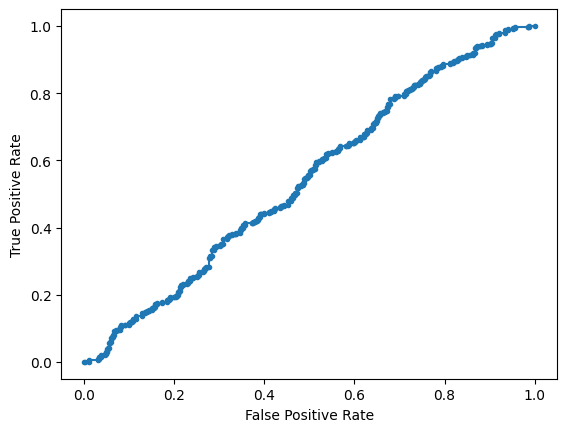

Accuracy: 52.41% Precision: 54.93% Recall: 53.49%
F1: 54.20% MCC: 0.0470
AUPRC: 53.99% AUROC: 54.30%
 accuracy [52.41379310344828]
 precision [54.932735426008975]
 recall [53.493449781659386]
 F1 [54.20353982300885]
 MCC [0.047019614501734114]
 AUPRC [53.98678831978724]
 AUROC [54.297918344850984]
2023-03-27 15:05:57.257807

Training # 1 2
2023-03-27 15:05:57.257863
2023-03-27 15:05:57.257886
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 15:05:57.367622


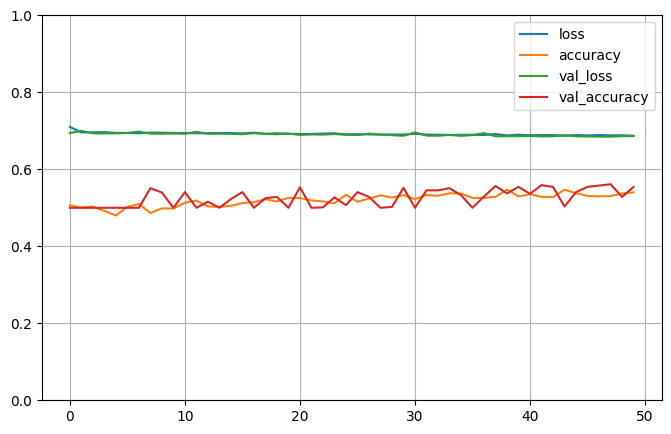


2023-03-27 15:06:21.300116

Testing # 1 2
2023-03-27 15:06:21.300170
2023-03-27 15:06:21.300188
PREDICT
2023-03-27 15:06:21.305449
Test 1:0 442:442 50.00%
Predict 1:0 690:194 78.05%
Test sizes (884, 257) (884,)
Range of scores: 0.3464241 to 0.5804838
Score threshold 0.5
Confusion matrix
 [[121 321]
 [ 73 369]]
Normalized matrix
 [[0.13687783 0.36312217]
 [0.08257919 0.41742081]]


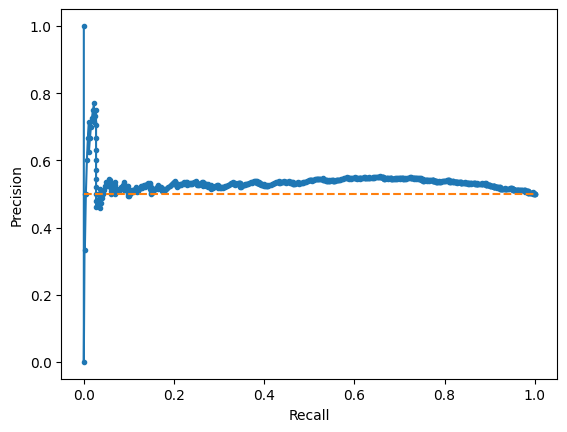

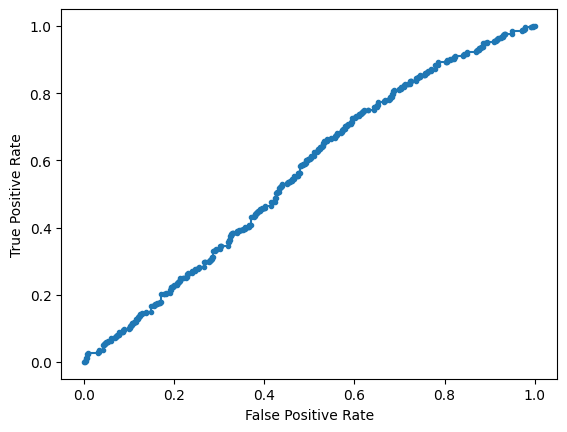

Accuracy: 55.43% Precision: 53.48% Recall: 83.48%
F1: 65.19% MCC: 0.1312
AUPRC: 53.31% AUROC: 56.07%
 accuracy [55.42986425339367]
 precision [53.47826086956522]
 recall [83.48416289592761]
 F1 [65.19434628975266]
 MCC [0.13119455991170448]
 AUPRC [53.30506942096028]
 AUROC [56.069183677647885]
2023-03-27 15:06:21.908375

Training # 1 3
2023-03-27 15:06:21.908436
2023-03-27 15:06:21.908461
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 15:06:21.995883


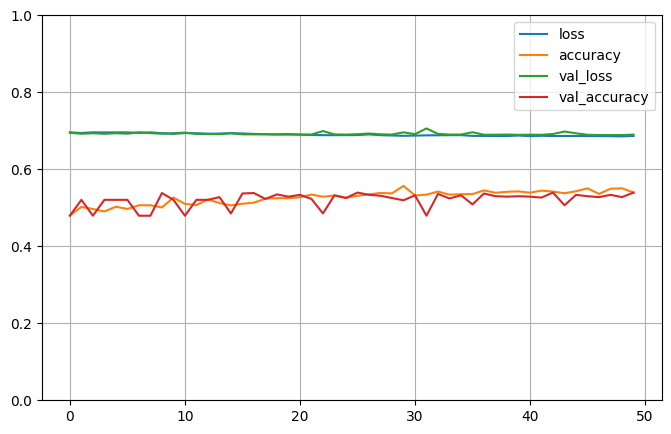


2023-03-27 15:06:39.271305

Testing # 1 3
2023-03-27 15:06:39.271354
2023-03-27 15:06:39.271369
PREDICT
2023-03-27 15:06:39.276409
Test 1:0 442:407 52.06%
Predict 1:0 517:332 60.90%
Test sizes (849, 257) (849,)
Range of scores: 0.2609039 to 0.5461335
Score threshold 0.5
Confusion matrix
 [[174 233]
 [158 284]]
Normalized matrix
 [[0.204947   0.27444052]
 [0.1861013  0.33451119]]


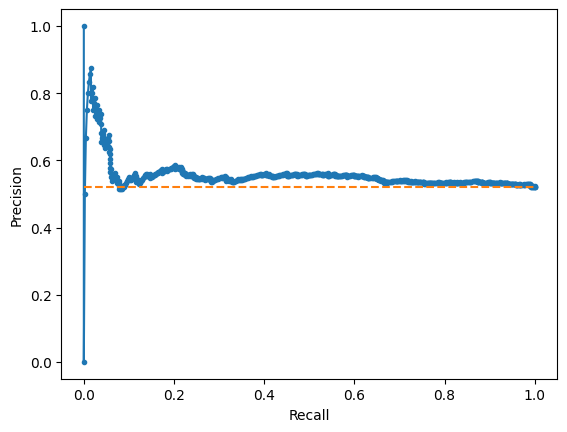

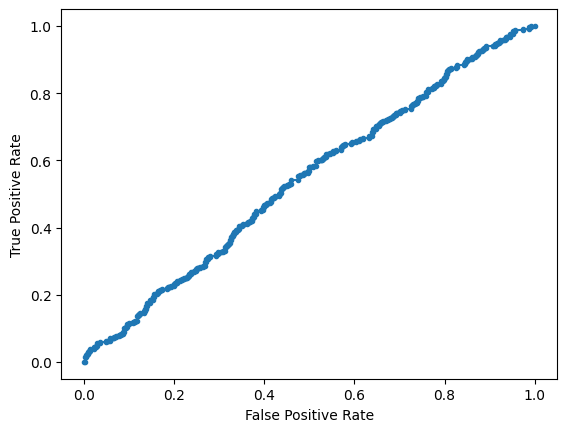

Accuracy: 53.95% Precision: 54.93% Recall: 64.25%
F1: 59.23% MCC: 0.0717
AUPRC: 55.51% AUROC: 54.12%
 accuracy [53.94581861012956]
 precision [54.932301740812385]
 recall [64.25339366515837]
 F1 [59.22836287799792]
 MCC [0.07171612616851725]
 AUPRC [55.51120396404343]
 AUROC [54.12131588602177]
2023-03-27 15:06:39.830455

Training # 1 4
2023-03-27 15:06:39.830533
2023-03-27 15:06:39.830566
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 15:06:39.905344


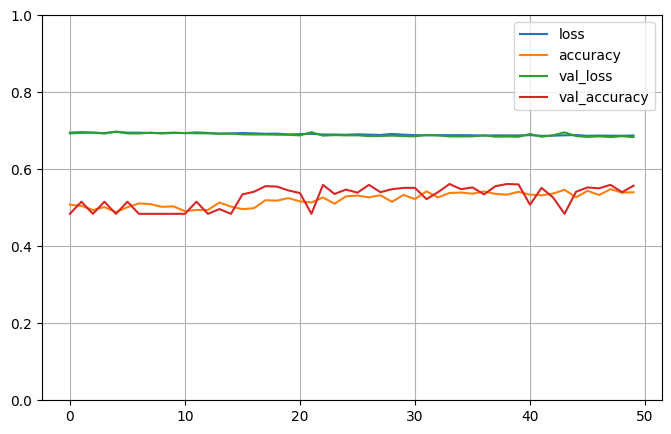


2023-03-27 15:07:01.243309

Testing # 1 4
2023-03-27 15:07:01.243368
2023-03-27 15:07:01.243385
PREDICT
2023-03-27 15:07:01.250927
Test 1:0 459:431 51.57%
Predict 1:0 621:269 69.78%
Test sizes (890, 257) (890,)
Range of scores: 0.2762537 to 0.56238186
Score threshold 0.5
Confusion matrix
 [[153 278]
 [116 343]]
Normalized matrix
 [[0.17191011 0.31235955]
 [0.13033708 0.38539326]]


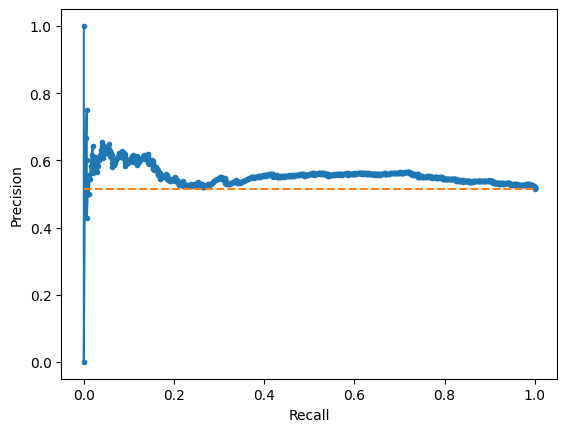

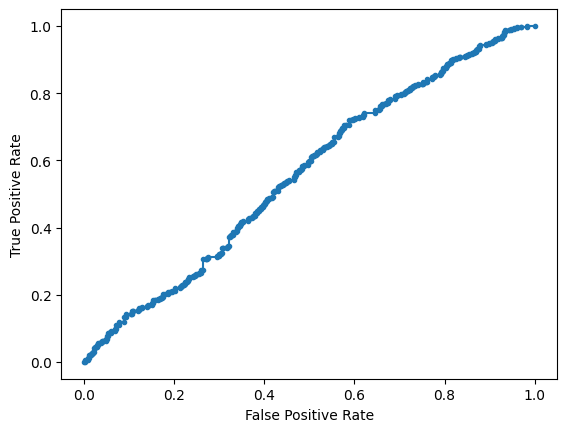

Accuracy: 55.73% Precision: 55.23% Recall: 74.73%
F1: 63.52% MCC: 0.1113
AUPRC: 55.50% AUROC: 55.98%
 accuracy [55.73033707865168]
 precision [55.23349436392915]
 recall [74.7276688453159]
 F1 [63.51851851851852]
 MCC [0.11128853672690062]
 AUPRC [55.49737898729633]
 AUROC [55.98067017474687]
2023-03-27 15:07:02.056848

Training # 1 5
2023-03-27 15:07:02.056933
2023-03-27 15:07:02.056972
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 15:07:02.146621


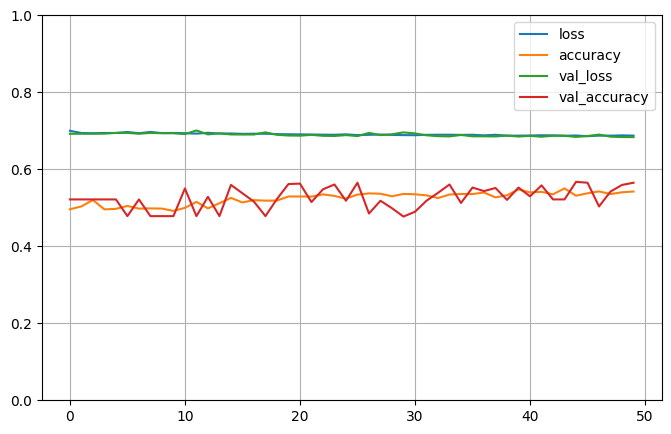


2023-03-27 15:07:19.681747

Testing # 1 5
2023-03-27 15:07:19.681786
2023-03-27 15:07:19.681800
PREDICT
2023-03-27 15:07:19.687368
Test 1:0 457:419 52.17%
Predict 1:0 688:188 78.54%
Test sizes (876, 257) (876,)
Range of scores: 0.30646786 to 0.5858822
Score threshold 0.5
Confusion matrix
 [[113 306]
 [ 75 382]]
Normalized matrix
 [[0.12899543 0.34931507]
 [0.08561644 0.43607306]]


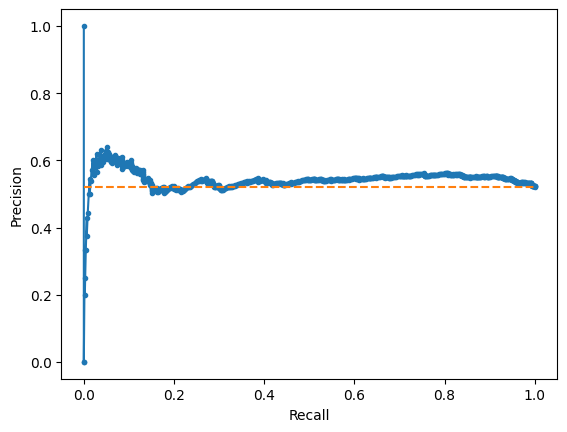

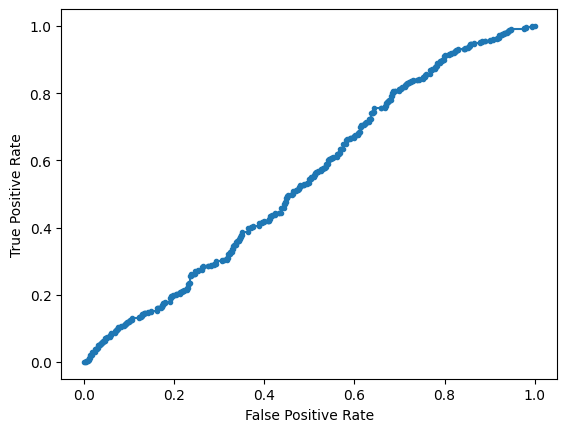

Accuracy: 56.51% Precision: 55.52% Recall: 83.59%
F1: 66.72% MCC: 0.1285
AUPRC: 54.37% AUROC: 54.40%
 accuracy [56.5068493150685]
 precision [55.52325581395349]
 recall [83.58862144420132]
 F1 [66.72489082969432]
 MCC [0.128456762904115]
 AUPRC [54.37223192534233]
 AUROC [54.40117399455826]
2023-03-27 15:07:20.303449

Training # 2 1
2023-03-27 15:07:20.303520
2023-03-27 15:07:20.303548
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 15:07:20.376075


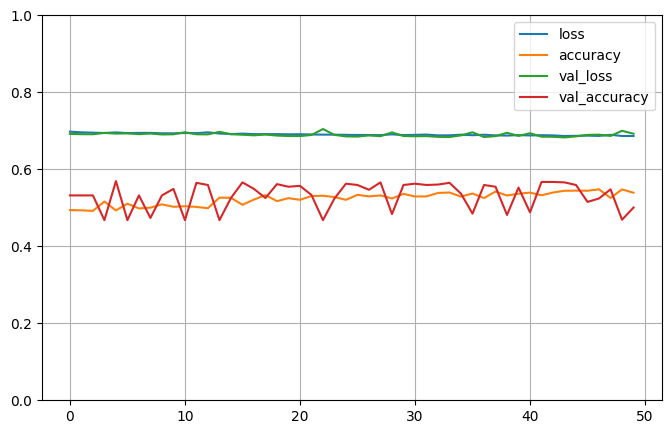


2023-03-27 15:07:39.939288

Testing # 2 1
2023-03-27 15:07:39.939365
2023-03-27 15:07:39.939384
PREDICT
2023-03-27 15:07:39.944791
Test 1:0 472:415 53.21%
Predict 1:0 303:584 34.16%
Test sizes (887, 257) (887,)
Range of scores: 0.24740896 to 0.5227684
Score threshold 0.5
Confusion matrix
 [[278 137]
 [306 166]]
Normalized matrix
 [[0.31341601 0.15445321]
 [0.34498309 0.18714769]]


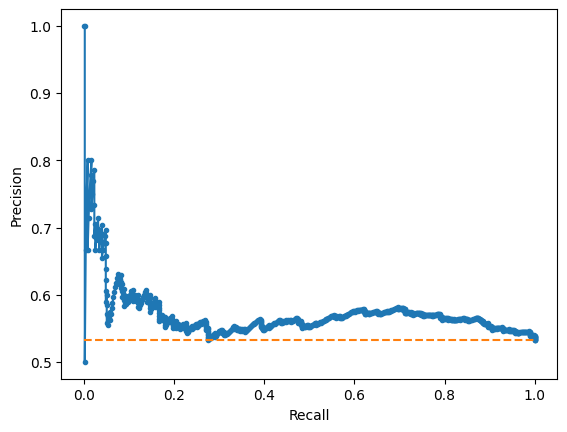

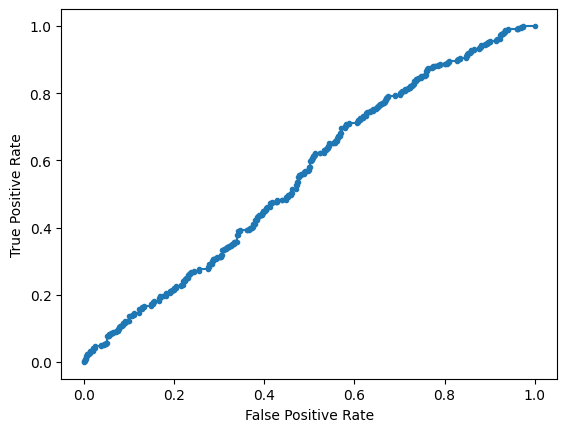

Accuracy: 50.06% Precision: 54.79% Recall: 35.17%
F1: 42.84% MCC: 0.0227
AUPRC: 57.16% AUROC: 55.58%
 accuracy [50.05636978579482]
 precision [54.78547854785478]
 recall [35.16949152542373]
 F1 [42.83870967741936]
 MCC [0.022698999079048224]
 AUPRC [57.16339970069079]
 AUROC [55.581478456197665]
2023-03-27 15:07:40.510675

Training # 2 2
2023-03-27 15:07:40.510748
2023-03-27 15:07:40.510786
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 15:07:40.586553


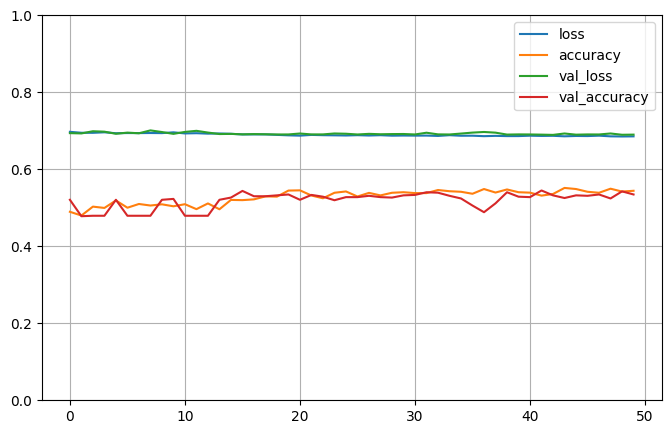


2023-03-27 15:08:00.292348

Testing # 2 2
2023-03-27 15:08:00.292394
2023-03-27 15:08:00.292407
PREDICT
2023-03-27 15:08:00.297755
Test 1:0 452:416 52.07%
Predict 1:0 540:328 62.21%
Test sizes (868, 257) (868,)
Range of scores: 0.25048685 to 0.54912347
Score threshold 0.5
Confusion matrix
 [[170 246]
 [158 294]]
Normalized matrix
 [[0.19585253 0.28341014]
 [0.18202765 0.33870968]]


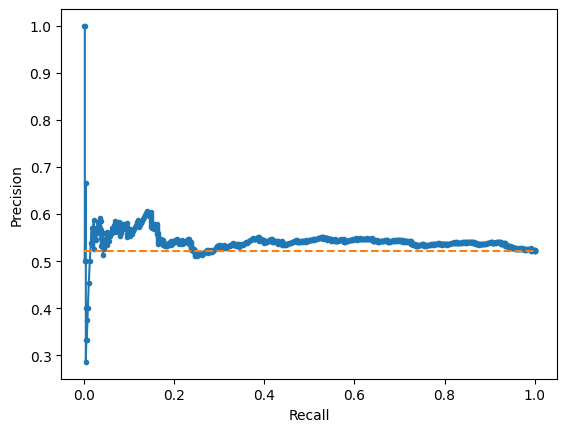

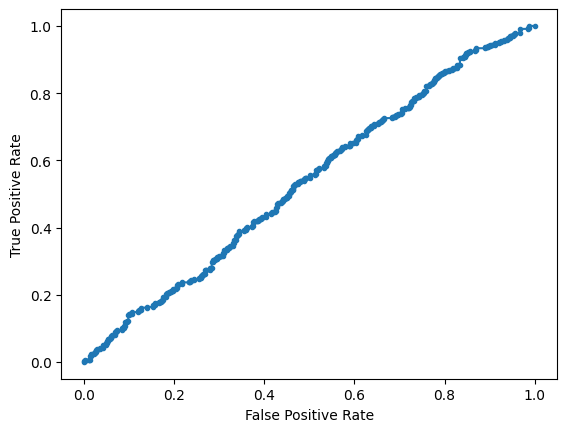

Accuracy: 53.46% Precision: 54.44% Recall: 65.04%
F1: 59.27% MCC: 0.0609
AUPRC: 54.26% AUROC: 53.50%
 accuracy [53.45622119815668]
 precision [54.44444444444444]
 recall [65.04424778761062]
 F1 [59.2741935483871]
 MCC [0.06088951968804799]
 AUPRC [54.25947049380434]
 AUROC [53.50445668822329]
2023-03-27 15:08:00.965216

Training # 2 3
2023-03-27 15:08:00.965299
2023-03-27 15:08:00.965336
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 15:08:01.036674


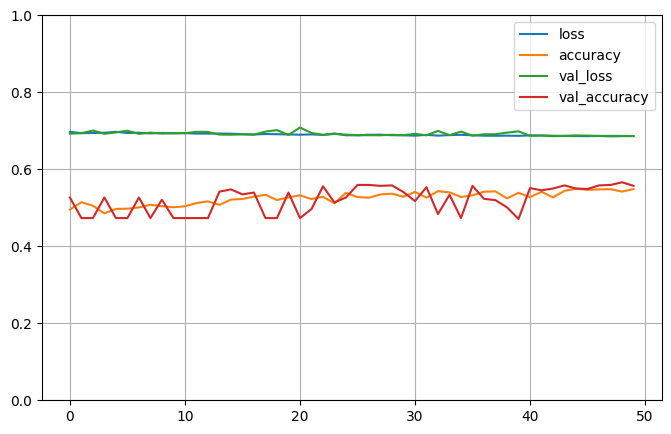


2023-03-27 15:08:18.082947

Testing # 2 3
2023-03-27 15:08:18.082984
2023-03-27 15:08:18.082998
PREDICT
2023-03-27 15:08:18.088782
Test 1:0 453:407 52.67%
Predict 1:0 650:210 75.58%
Test sizes (860, 257) (860,)
Range of scores: 0.29085746 to 0.58437836
Score threshold 0.5
Confusion matrix
 [[118 289]
 [ 92 361]]
Normalized matrix
 [[0.1372093  0.33604651]
 [0.10697674 0.41976744]]


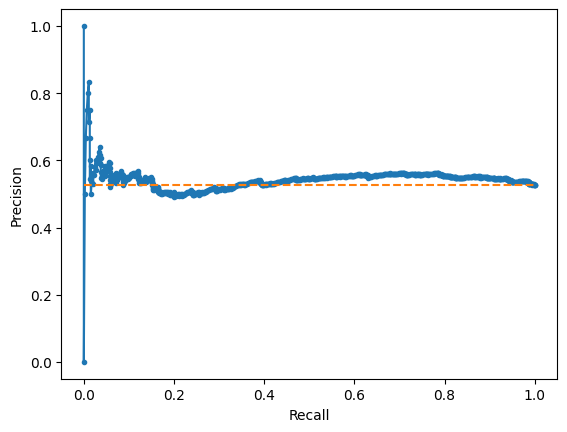

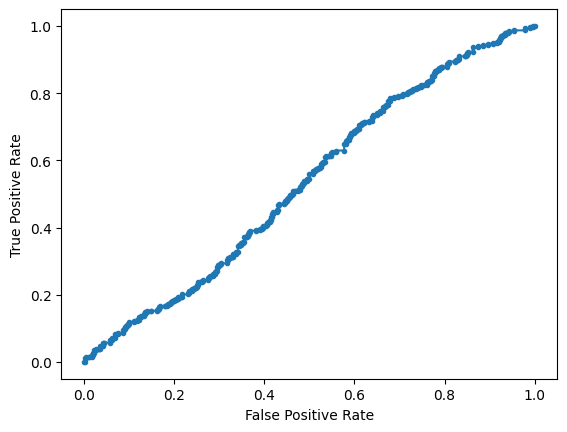

Accuracy: 55.70% Precision: 55.54% Recall: 79.69%
F1: 65.46% MCC: 0.1009
AUPRC: 54.25% AUROC: 53.42%
 accuracy [55.69767441860465]
 precision [55.53846153846153]
 recall [79.69094922737307]
 F1 [65.45784224841343]
 MCC [0.10092033898415328]
 AUPRC [54.250816142551784]
 AUROC [53.41539613062791]
2023-03-27 15:08:18.642475

Training # 2 4
2023-03-27 15:08:18.642545
2023-03-27 15:08:18.642572
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 15:08:18.714755


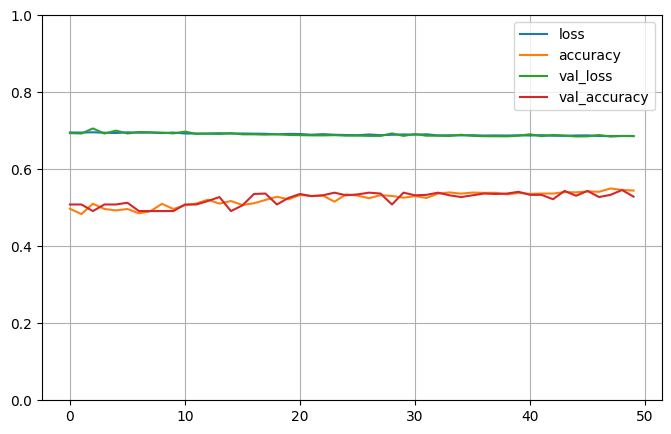


2023-03-27 15:08:35.465114

Testing # 2 4
2023-03-27 15:08:35.465159
2023-03-27 15:08:35.465176
PREDICT
2023-03-27 15:08:35.473033
Test 1:0 432:447 49.15%
Predict 1:0 326:553 37.09%
Test sizes (879, 257) (879,)
Range of scores: 0.24017645 to 0.52210647
Score threshold 0.5
Confusion matrix
 [[293 154]
 [260 172]]
Normalized matrix
 [[0.33333333 0.17519909]
 [0.29579067 0.19567691]]


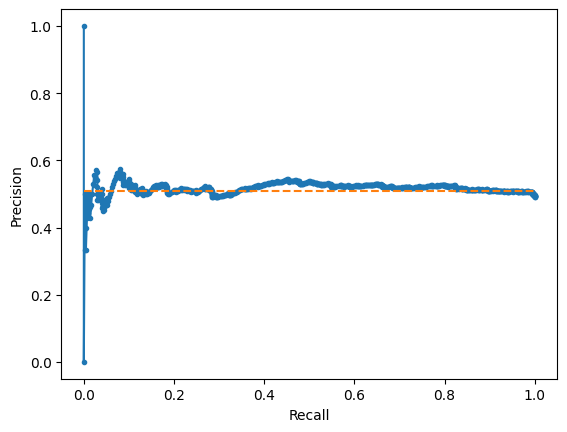

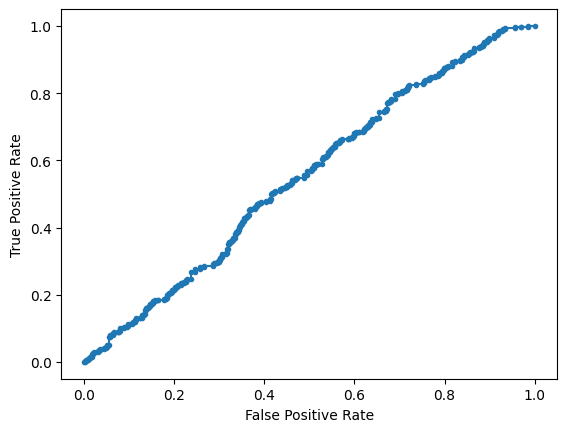

Accuracy: 52.90% Precision: 52.76% Recall: 39.81%
F1: 45.38% MCC: 0.0555
AUPRC: 51.68% AUROC: 55.08%
 accuracy [52.901023890784984]
 precision [52.760736196319016]
 recall [39.81481481481482]
 F1 [45.38258575197889]
 MCC [0.05550409695185268]
 AUPRC [51.67768555281367]
 AUROC [55.082753334990464]
2023-03-27 15:08:36.210687

Training # 2 5
2023-03-27 15:08:36.210747
2023-03-27 15:08:36.210771
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 15:08:36.292356


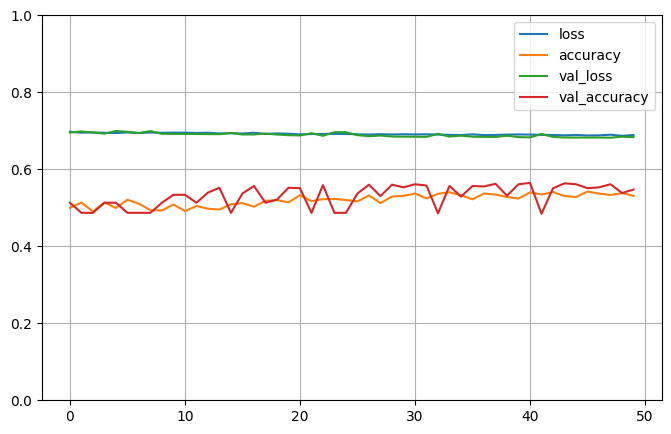


2023-03-27 15:08:54.381847

Testing # 2 5
2023-03-27 15:08:54.381919
2023-03-27 15:08:54.381943
PREDICT
2023-03-27 15:08:54.387662
Test 1:0 449:426 51.31%
Predict 1:0 417:458 47.66%
Test sizes (875, 257) (875,)
Range of scores: 0.3110691 to 0.5382344
Score threshold 0.5
Confusion matrix
 [[244 182]
 [214 235]]
Normalized matrix
 [[0.27885714 0.208     ]
 [0.24457143 0.26857143]]


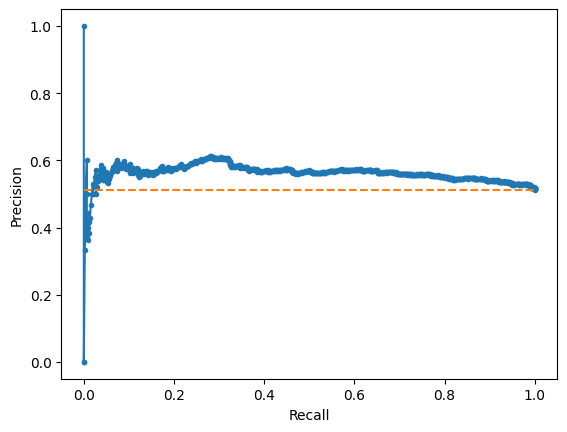

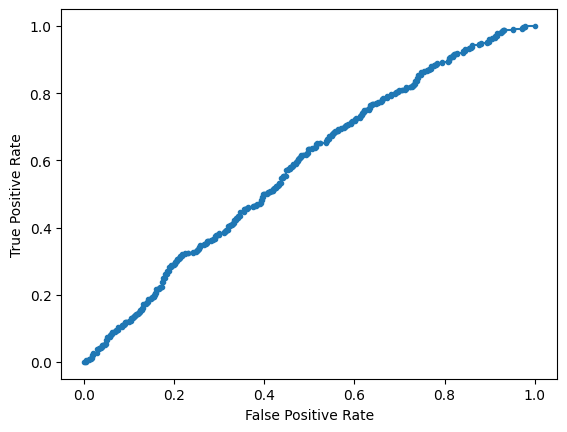

Accuracy: 54.74% Precision: 56.35% Recall: 52.34%
F1: 54.27% MCC: 0.0962
AUPRC: 56.17% AUROC: 58.07%
 accuracy [54.74285714285714]
 precision [56.35491606714629]
 recall [52.338530066815146]
 F1 [54.27251732101617]
 MCC [0.0962277257361525]
 AUPRC [56.16731952029211]
 AUROC [58.07323525413805]
2023-03-27 15:08:54.959793


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 54.09% std 1.95
 precision mean 54.80% std 1.04
 recall mean 63.16% std 17.58
 F1 mean 57.61% std 8.39
 MCC mean 0.08% std 0.04
 AUPRC mean 54.62% std 1.55
 AUROC mean 55.05% std 1.42
 accuracy [[52.41379310344828], [55.42986425339367], [53.94581861012956], [55.73033707865168], [56.5068493150685], [50.05636978579482], [53.45622119815668], [55.69767441860465], [52.901023890784984], [54.74285714285714]]
 precision [[54.932735426008975], [53.47826086956522], [54.932301740812385], [55.23349436392915], [55.52325581395349], [54.78547854785478], [54.44444444444444], [55.53846153846153], [52.760736196319016], [56.35491606714629]]
 recall [[53.493449781659386], [83.48416289592761], [64.25339366515837], [74.7276688453159], [83.58862144420132], [35.16949152542373], [65.04424778761062], [79.69094922737307], [39.81481481481482], [52.338530066815146]]
 F1 [[54.20353982300885], [65.19434628975266], [59.22836287799792], [63.51851851851852], [66.72489082969432], [42.83870967741936], [59.